<a href="https://colab.research.google.com/github/duonghung86/Vehicle-trajectory-tracking/blob/master/Codes/VTP_1_10_Models_for_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing models for full dataset
---

## Import packages

In [1]:
# General
import numpy as np
import time
import os

# Loading datasets
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request

# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# For prediction model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

## Load dataset

In [18]:
def url2pd(link):
    with ZipFile(link) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading dataset %s !' % link)
    return pd.read_csv(data)

In [3]:
filenames = os.listdir('./Data')
filenames

['0750_0805_us101_smoothed_11_.zip',
 '0805_0820_us101_smoothed_11_.zip',
 '0820_0835_us101_smoothed_11_.zip',
 'trajectories-0400-0415.zip',
 'trajectories-0500-0515.zip',
 'trajectories-0515-0530.zip']

In [9]:
# Set constant values
HISTORY_LENGTH = 3
FUTURE_LENGTH = 5
n_steps = int(HISTORY_LENGTH/0.2)
n_future = int(FUTURE_LENGTH/0.2)
n_features = len(df)
target_names = ['Local_X','v_Vel']

In [20]:
def single_series2seq(series,past=4,future=1,past_step=1, future_step=1):
    # length of sequences 
    length = past + future
    seq = series.copy()
    # add rolled series
    for i in range(length-1):
        seq = np.vstack((seq,np.roll(series,i+1)))
    seq = np.flip(seq.T,1)
    seq = seq[length-1:,:]
    # Prepare output
    X = seq[:,:past:past_step]
    Y = seq[:,past::future_step]
    return X,Y
data = np.arange(10)
single_series2seq(data,past = 3, future = 4,future_step=2)

(array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]]),
 array([[3, 5],
        [4, 6],
        [5, 7],
        [6, 8]]))

In [21]:
def multi_series2seq(mulseries,**kwarg):
    # number of series
    n_series = mulseries.shape[1]
    seq = mulseries.copy()
    X,Y = single_series2seq(seq[:,0],past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
    for i in range(1,n_series):
        newX,newY = single_series2seq(seq[:,i],past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
        X = np.column_stack((X,newX))
        Y = np.column_stack((Y,newY))
    return X,Y
data = np.arange(20).reshape(-1,2)
multi_series2seq(mulseries = data,past = 3, future = 4,future_step=1)

(array([[ 0,  2,  4,  1,  3,  5],
        [ 2,  4,  6,  3,  5,  7],
        [ 4,  6,  8,  5,  7,  9],
        [ 6,  8, 10,  7,  9, 11]]),
 array([[ 6,  8, 10, 12,  7,  9, 11, 13],
        [ 8, 10, 12, 14,  9, 11, 13, 15],
        [10, 12, 14, 16, 11, 13, 15, 17],
        [12, 14, 16, 18, 13, 15, 17, 19]]))

In [23]:
# multiple objects
def multi_obj2seq(data, **kwarg):
    veh_ids = data.Vehicle_ID.unique()
    X,Y = np.array([]), np.array([])
    for id in veh_ids:
        dat = data[data.Vehicle_ID==id][target_names].copy()
        newX,newY = multi_series2seq(dat.values ,past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
        #print(X.shape, newX.shape)
        X = np.vstack((X,newX)) if X.size else newX
        Y = np.vstack((Y,newY)) if Y.size else newY
        #print(X.shape)
    if kwarg["show_result"]:
        print(X.shape)
        print(Y.shape)
    return X, Y

In [24]:
X,Y = np.array([]), np.array([])
for file in filenames:
    print(file)
    url = './Data/' + file
    df = url2pd(url)
    # Filter time step
    print(df.shape)
    df = df.iloc[::2,:].copy()
    df.reset_index(drop=True, inplace=True)
    print('After filtering:', df.shape)
    #  keep only columns that are useful for now
    kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Length', 'v_Width', 'v_Class',
           'v_Vel', 'v_Acc', 'Lane_ID']
    df = df[kept_cols]
    print('The number of vehicles is {}'.format(len(df.Vehicle_ID.unique())))
    print('Converting to sequences ...')
    newX, newY = multi_obj2seq(df,past = n_steps, future = n_future,future_step=5, show_result=True)
    X = np.vstack((X,newX)) if X.size else newX
    Y = np.vstack((Y,newY)) if Y.size else newY

0750_0805_us101_smoothed_11_.zip
Done loading dataset ./Data/0750_0805_us101_smoothed_11_.zip !
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1993
Converting to sequences ...
(446561, 30)
(446561, 10)
0805_0820_us101_smoothed_11_.zip
Done loading dataset ./Data/0805_0820_us101_smoothed_11_.zip !
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1533
Converting to sequences ...
(464501, 30)
(464501, 10)
0820_0835_us101_smoothed_11_.zip
Done loading dataset ./Data/0820_0835_us101_smoothed_11_.zip !
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1298
Converting to sequences ...
(473671, 30)
(473671, 10)
trajectories-0400-0415.zip
Done loading dataset ./Data/trajectories-0400-0415.zip !
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1725
Converting to sequences ...
(457013, 30)
(457013, 10)
trajectories-0500-0515.zip
Done loading dataset ./Data/trajectories-0500-0515.zip !
(1048575, 18)
After filterin

### Split the data set


In [25]:
X.shape, Y.shape

((2786660, 30), (2786660, 10))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(1950662, 30) (835998, 30) (1950662, 10) (835998, 10)


In [27]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.mean(), X_train.std()

(1950662, 30)


(2.5300156106414927e-15, 0.999999999999999)

In [28]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))


In [29]:
X_train.shape,X_test.shape

((1950662, 30, 1), (835998, 30, 1))

## Prediction model

In [32]:
%%time
# define model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1],1)))
model.add(Dense(10))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=50, batch_size= 1024,
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1905/1905 [==============================] - 28s 12ms/step - loss: 542.8395 - mse: 542.8395 - val_loss: 74.5285 - val_mse: 74.5285
Epoch 2/50
1905/1905 [==============================] - 21s 11ms/step - loss: 48.1419 - mse: 48.1419 - val_loss: 17.4895 - val_mse: 17.4895
Epoch 3/50
1905/1905 [==============================] - 21s 11ms/step - loss: 15.8198 - mse: 15.8198 - val_loss: 13.1642 - val_mse: 13.1642
Epoch 4/50
1905/1905 [==============================] - 21s 11ms/step - loss: 12.7810 - mse: 12.7810 - val_loss: 12.1099 - val_mse: 12.1099
Epoch 5/50
1905/1905 [==============================] - 21s 11ms/step - loss: 12.0132 - mse: 12.0132 - val_loss: 11.8173 - val_mse: 11.8173
Epoch 6/50
1905/1905 [==============================] - 21s 11ms/step - loss: 11.7536 - mse: 11.7536 - val_loss: 11.6438 - val_mse: 11.6438
Epoch 7/50
1905/1905 [==============================] - 21s 11ms/step - loss: 11.6728 - mse: 11.6728 - val_loss: 11.6121 - val_mse: 11.6121
Epoch 8/50
1905/19

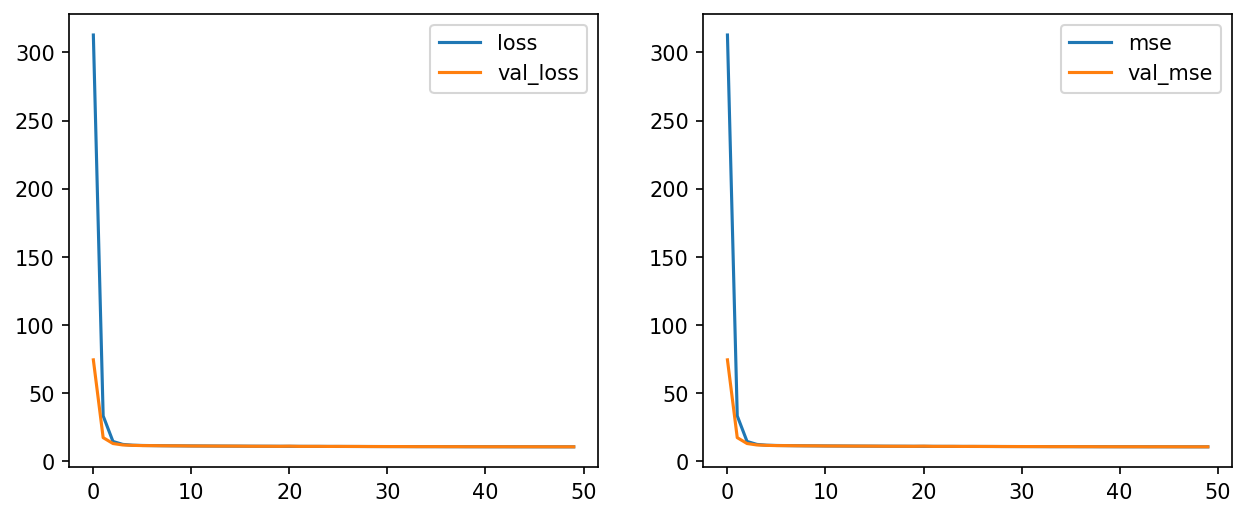

In [33]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()

## Evaluation 


In [34]:
loss, mse = model.evaluate(X_test,y_test, verbose=1)
sqrt(mse)

26125/26125 [==============================] - 73s 3ms/step - loss: 10.7609 - mse: 10.7609


3.2803764997113363

In [35]:
y_hat = model.predict(X_test, verbose=1)

26125/26125 [==============================] - 51s 2ms/step


In [ ]:
y_test.shape

In [39]:
colnames = [str(i)+'s' for i in range(1,6)]
rmse = np.sqrt(np.square(np.subtract(y_test,y_hat)).mean(0)).reshape(2,-1)
rmse = pd.DataFrame(rmse,columns = colnames, index = target_names )
rmse.round(3)

,1s,2s,3s,4s,5s
Local_X,0.351,0.632,0.969,1.262,1.526
v_Vel,1.130,3.312,4.385,5.437,6.418


# END